# Mini Project 2

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pyspark.mllib
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.getOrCreate()

In [3]:
from pyspark.sql.functions import col
from pyspark.sql.functions import log

In [4]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

C:\Program Files\spark-3.5.0-bin-hadoop3\python\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [5]:
import os
os.getcwd()

'C:\\Users\\Xue\\OneDrive - Oklahoma A and M System\\Jupyter\\BAN 5753\\Mini 2'

In [6]:
from platform import python_version

print(python_version())

3.11.4


In [7]:
sc.version #spark version

'3.5.0'

## Read File

In [8]:
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",",")\
 .csv("C:/Users/Xue/OneDrive - Oklahoma A and M System/BAN 5753/Mini project/mini 2/XYZ_Bank_Deposit_Data_Classification.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.") 

There are 41188 rows 21 columns in the data.


# 1. Exploratory Data Analysis (EDA)

## 1.1 Data Types of Columns

In [9]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



## 1.2 Statistics

In [10]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934057,17,98
duration,41188,258.2850101971448,259.279248836465,0,4918
campaign,41188,2.567592502670681,2.7700135429023245,1,56
pdays,41188,962.4754540157328,186.91090734474085,0,999
previous,41188,0.17296299893172767,0.4949010798392899,0,7


## 1.3 Check Null values
* there is no null values in the dataset

In [11]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1.5 Target Variable Distribution
* From target, we can see the data is unbalanced

In [12]:
df.groupby("y").count().show()

+---+-----+
|  y|count|
+---+-----+
| no|36548|
|yes| 4640|
+---+-----+



## 1.5 Univariate patterns - Distribution of Features of Numerical Variables
View Univariate Distributions

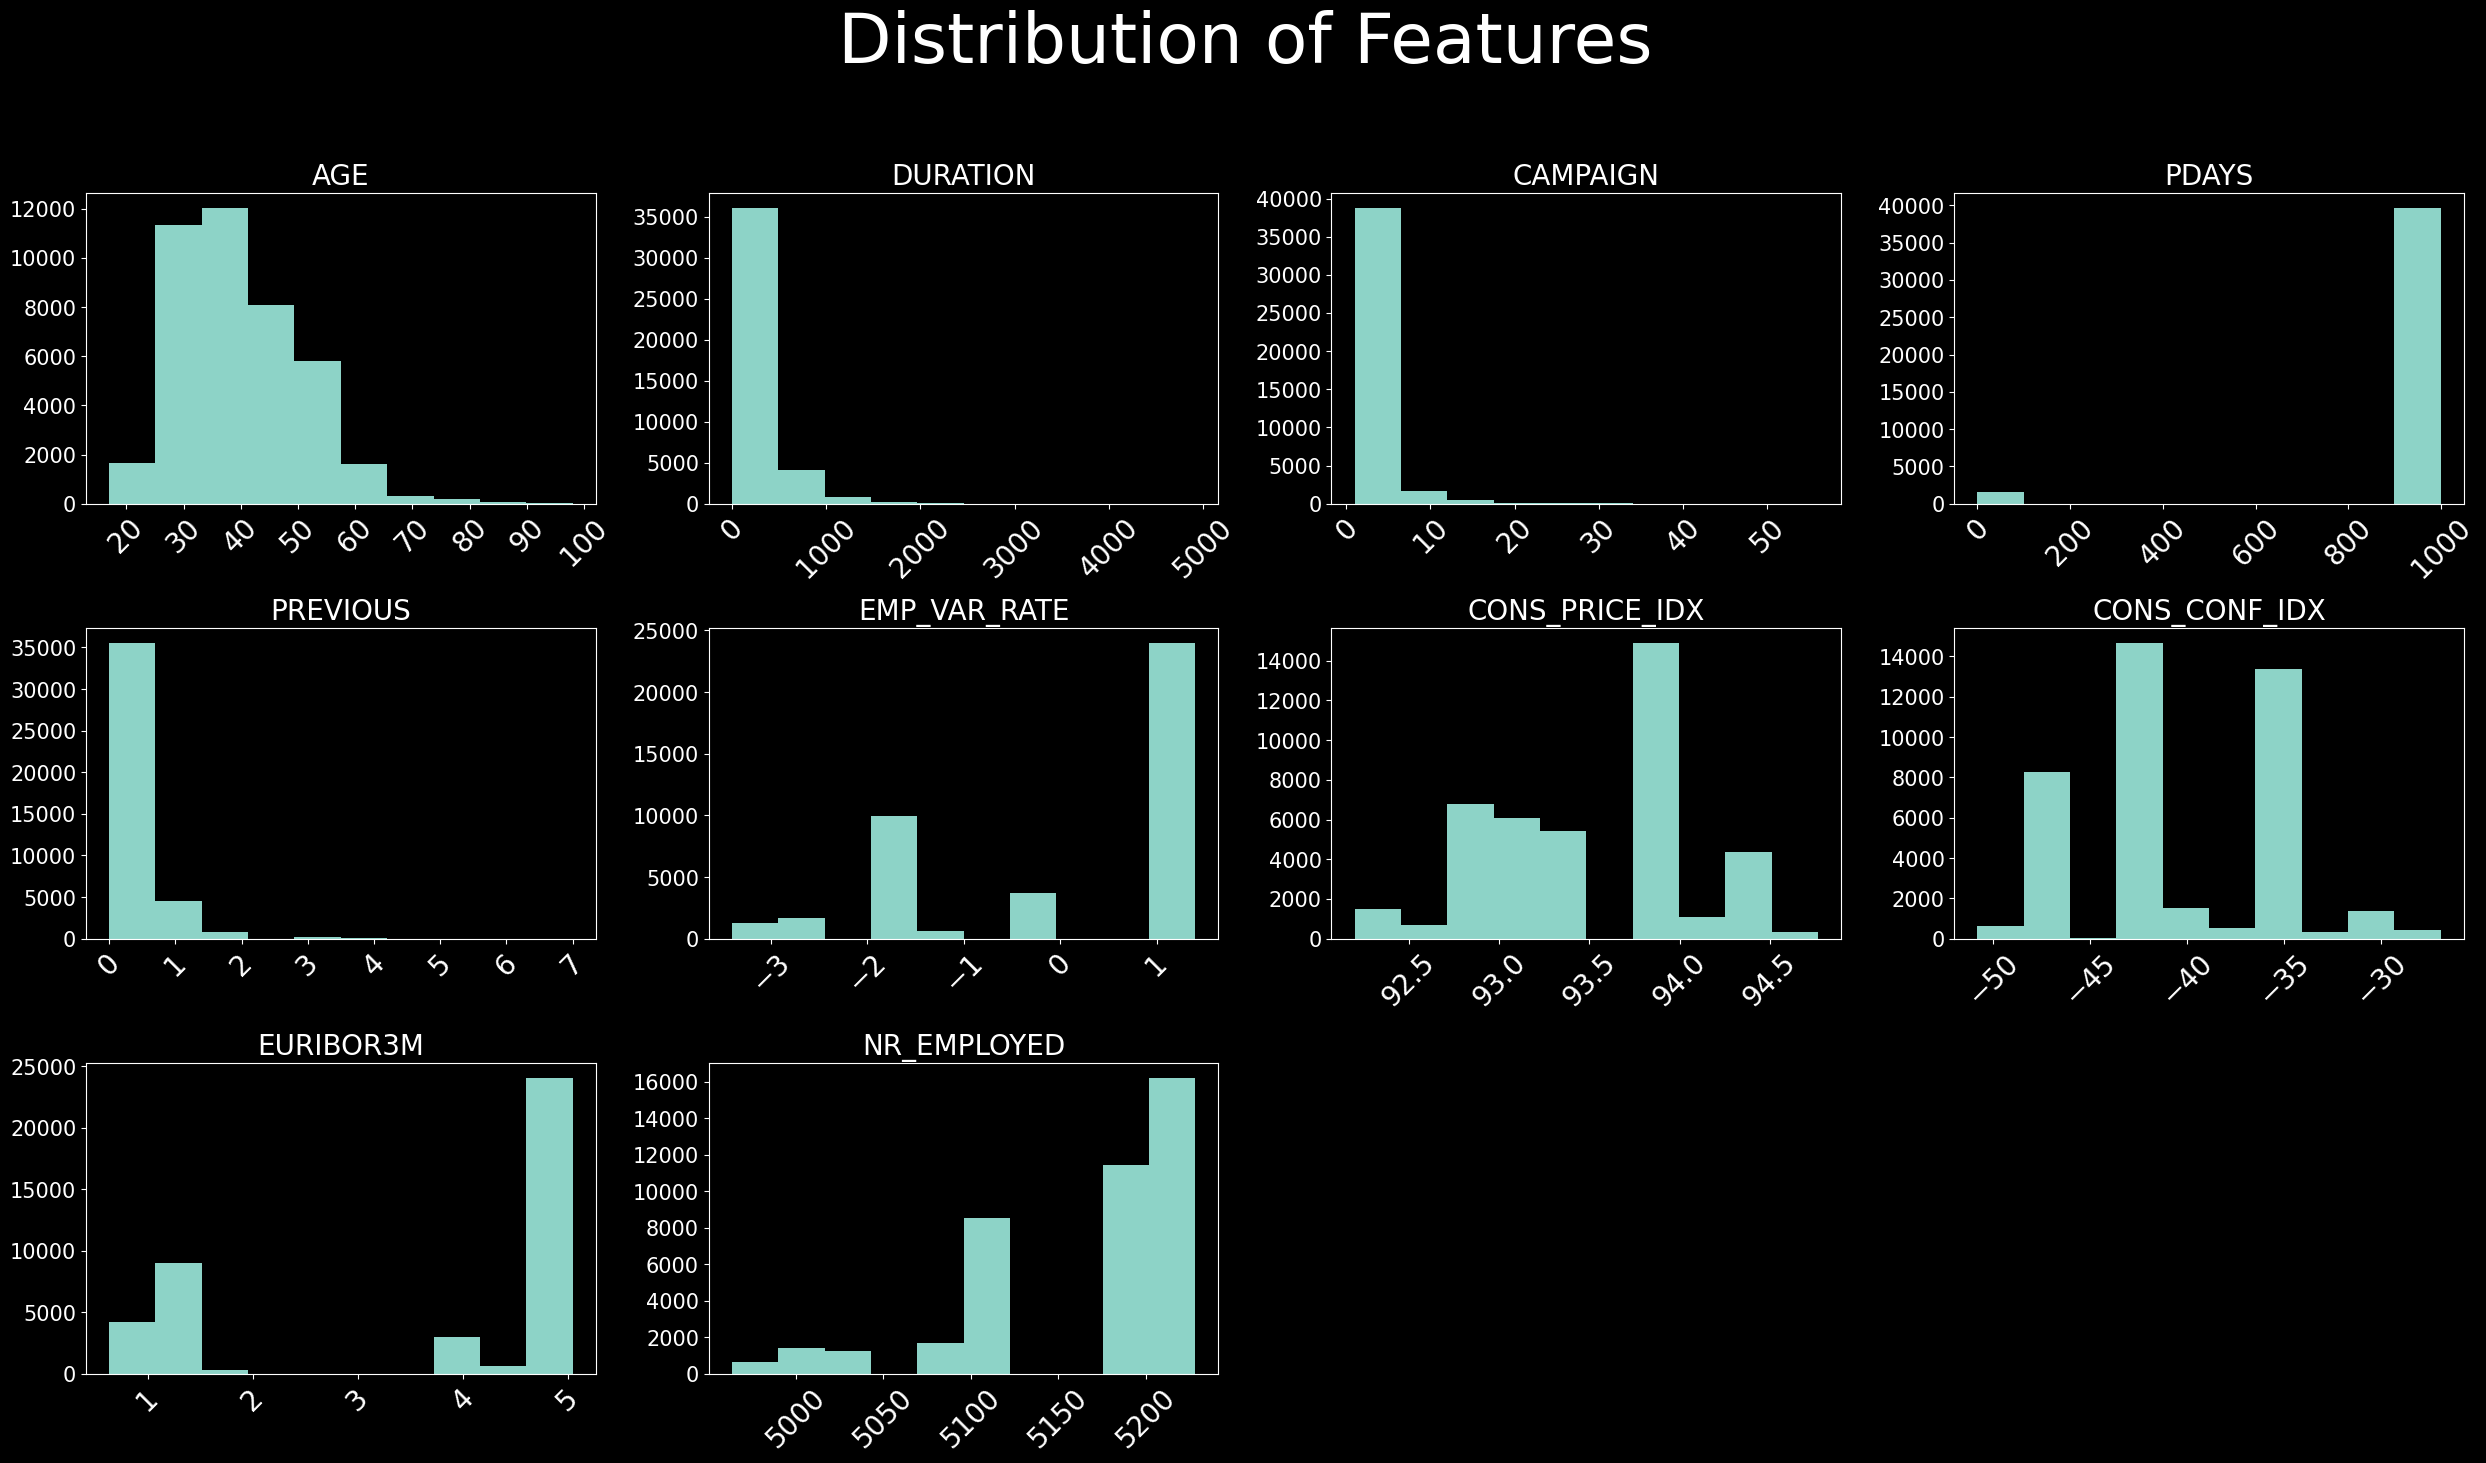

In [14]:
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().describe().columns, range(1,12)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
    plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

* Except 'AGE' is near normal distributed, all other variables are not normal distributed.
* These variables will be grouped into two categorices according to their distribution:
1. PDAYS
2. EURIBOR3M
* Others will be normalized using 'StandardScaler'.



## 1.6 Pearson Correlation
Identify correlations beteween variables

In [15]:
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
numeric_features_df=df.select(numeric_features)
numeric_features_df.toPandas().head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0


In [16]:
col_names =numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp_var_rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons_price_idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons_conf_idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr_employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


#### Below are the proposed guidelines for the Pearson coefficient correlation interpretation
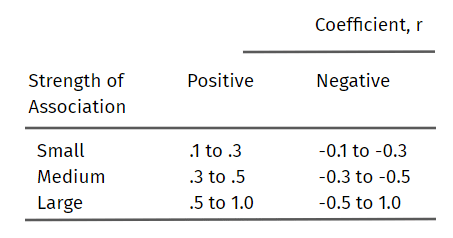
#### Accoring to this guidline,collinarity problem exist in these pairs:
* Emp_var_rate VS. cons_price_idx
* Emp_var_rate VS.euribor3m
* Emp_var_rate VS. nr_employed
* euribor3m VS. cons_price_idx
* euribor3m VS. nr_employed
* Pdays VS. previous
####  Deal with these two variables to solve collinearity problem:
* Emp_var_rate: remove it in modeling building
* euribor3m: change it to categorical variabe including two groups
* Pdays : change it to categorical variabe including two groups 

## 1.7 Univariate patterns - Distribution of Features of Categorical Variables

In [17]:
dtypes = df.dtypes
cat_columns = [col for col, dtype in dtypes if dtype == 'string']

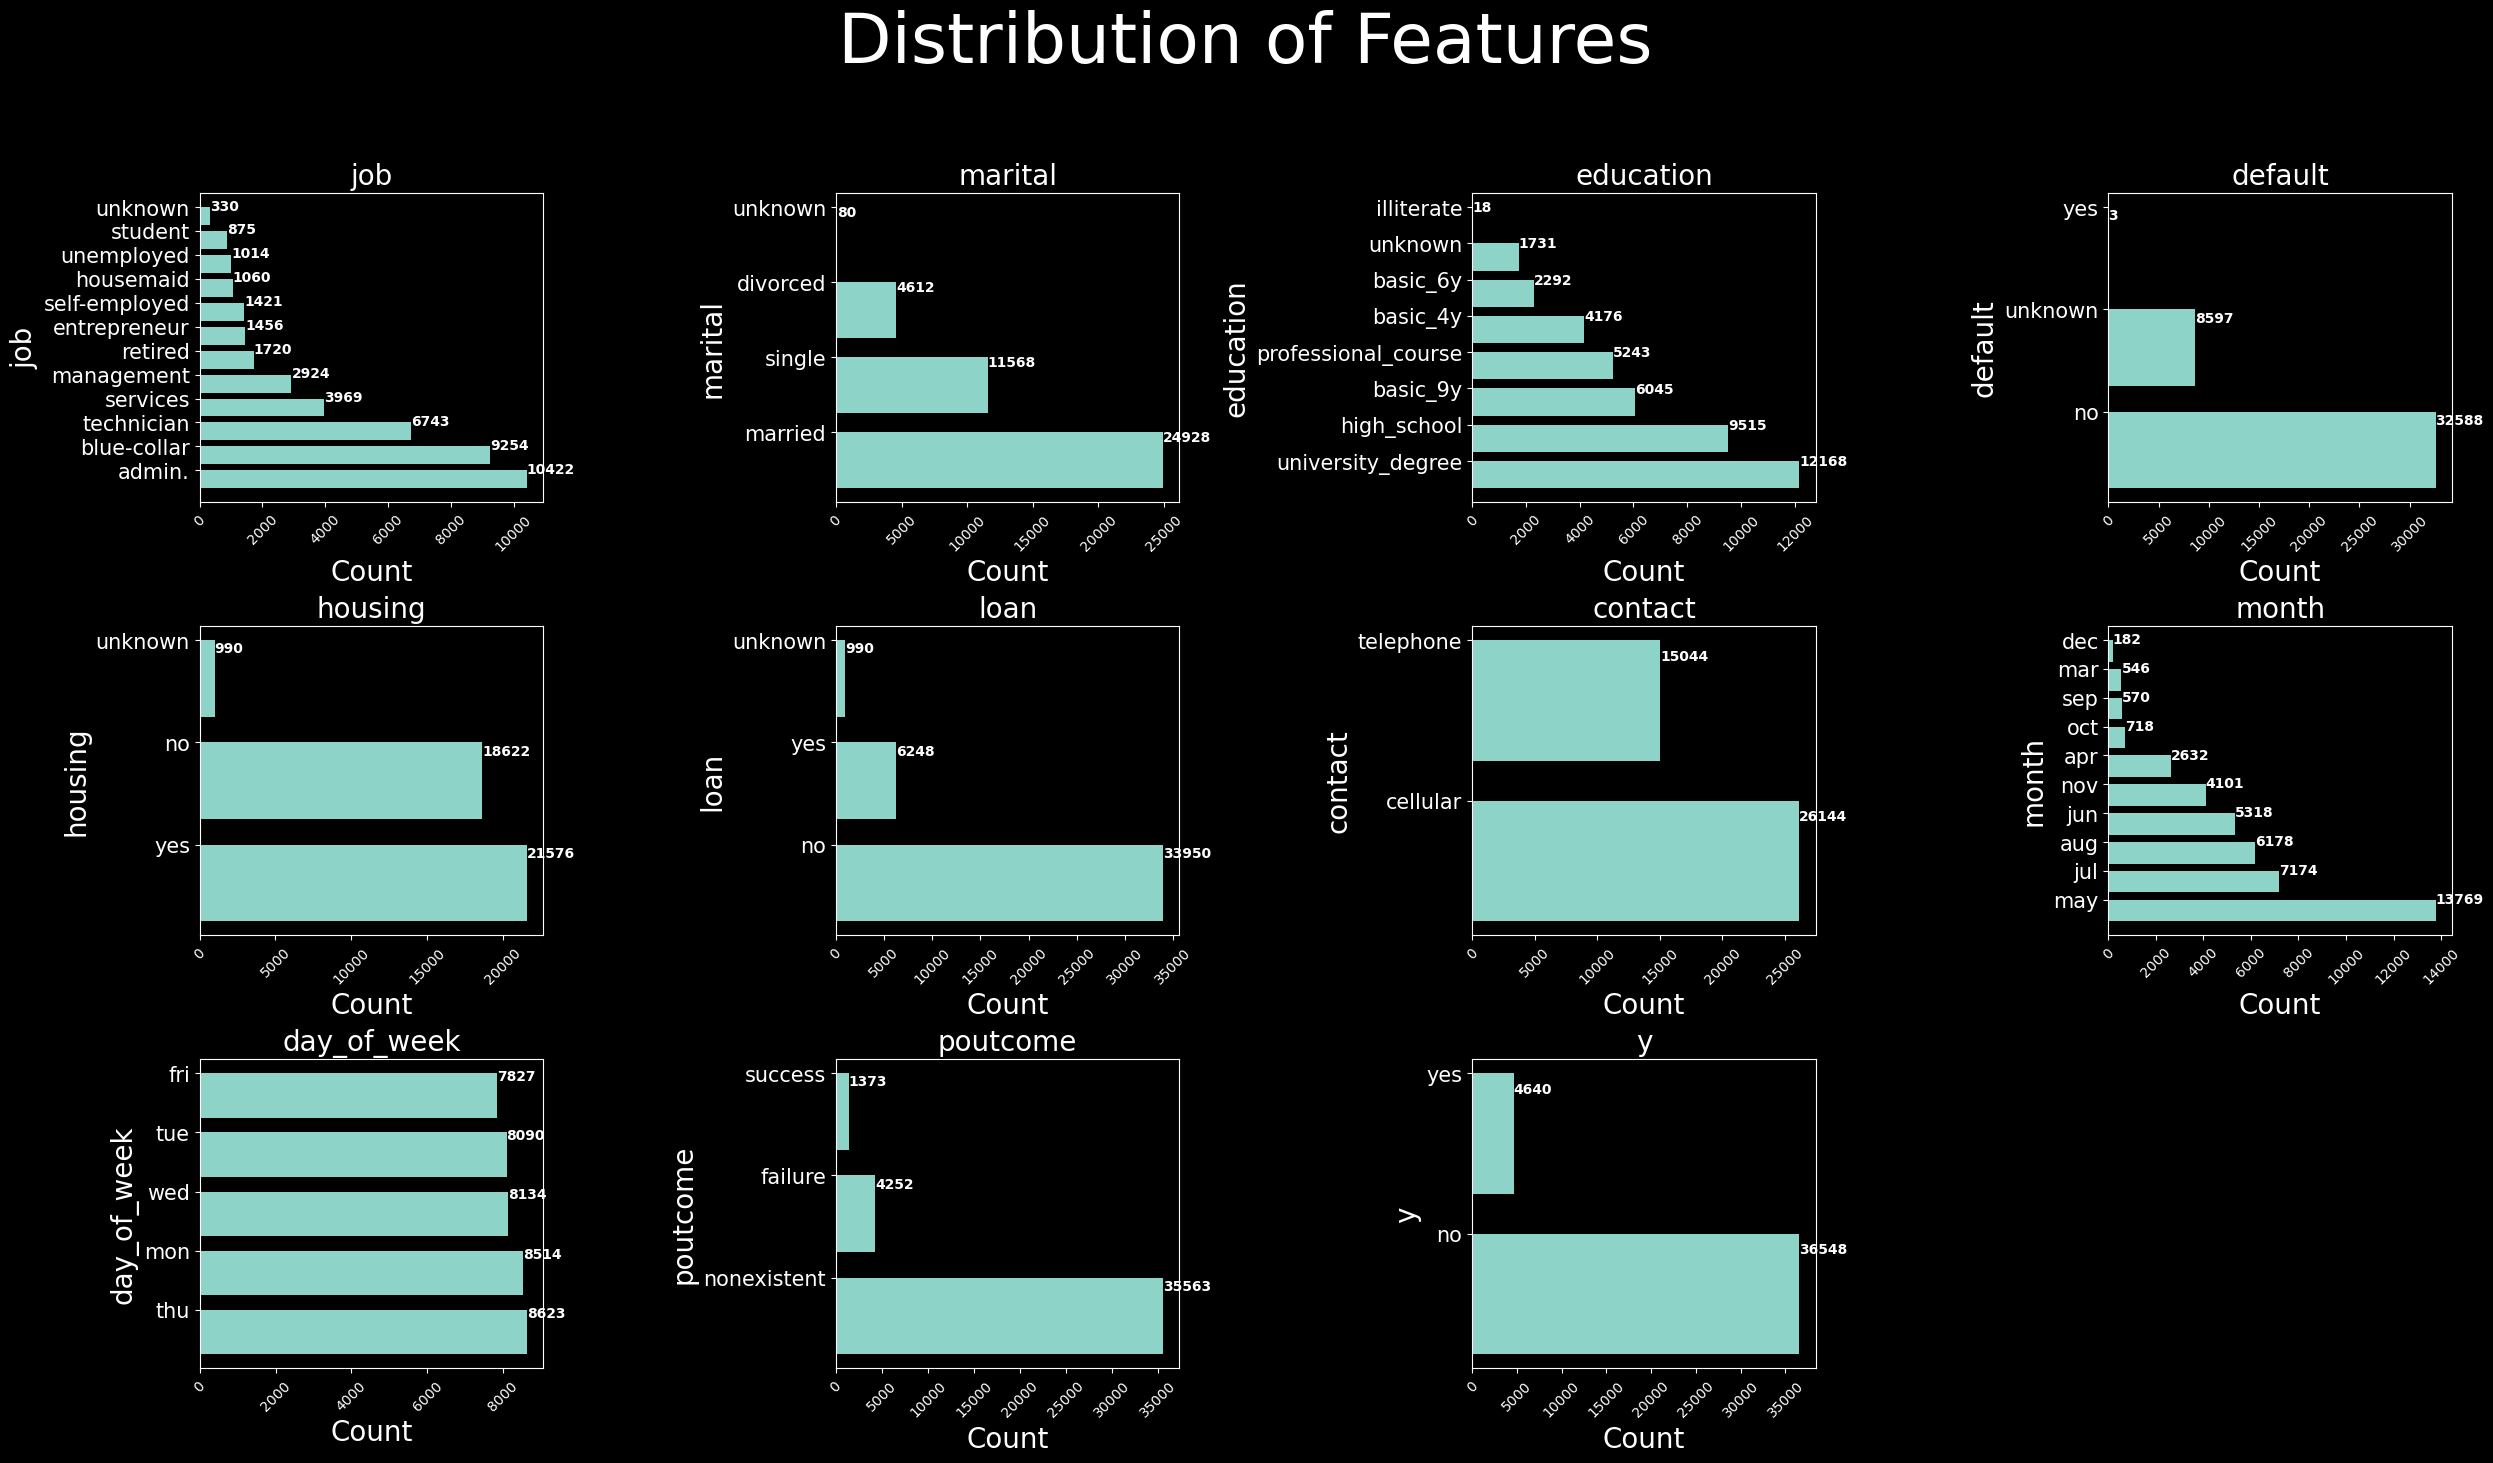

In [29]:
### We can plor distribution for each categorical Variable

from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(cat_columns, range(1,12)):
    a = df.toPandas()[col].value_counts()
    x = list(a.index)
    y = list(a)
    ax = fig.add_subplot(3,4,num)   
    width = 0.75 # the width of the bars 
    ind = np.arange(len(y))  # the x locations for the groups
    ax.barh(ind, y, width)
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(x, minor=False)
    for i, v in enumerate(y):
        ax.text(v + .25, i + .25, str(v), fontweight='bold') #add value labels into bar
    plt.title(col,fontsize=20)
    plt.xlabel('Count',fontsize=20)
    plt.ylabel(col,fontsize=20)
    plt.xticks(rotation=45,fontsize=10)
    plt.yticks(fontsize=15)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

In [30]:
# We can also check out counts of categorical variables
df.groupBy("job").count().orderBy("count", ascending=False).show(truncate=False)
df.groupBy("marital").count().orderBy("count", ascending=False).show(truncate=False)
df.groupBy("education").count().orderBy("count", ascending=False).show(truncate=False)
df.groupBy("default").count().orderBy("count", ascending=False).show(truncate=False)
df.groupBy("housing").count().orderBy("count", ascending=False).show(truncate=False)
df.groupBy("loan").count().orderBy("count", ascending=False).show(truncate=False)
df.groupBy("contact").count().orderBy("count", ascending=False).show(truncate=False)
df.groupBy("month").count().orderBy("count", ascending=False).show(truncate=False)
df.groupBy("day_of_week").count().orderBy("count", ascending=False).show(truncate=False)
df.groupBy("poutcome").count().orderBy("count", ascending=False).show(truncate=False)
df.groupBy("y").count().orderBy("count", ascending=False).show(truncate=False)
     

+-------------+-----+
|job          |count|
+-------------+-----+
|admin.       |10422|
|blue-collar  |9254 |
|technician   |6743 |
|services     |3969 |
|management   |2924 |
|retired      |1720 |
|entrepreneur |1456 |
|self-employed|1421 |
|housemaid    |1060 |
|unemployed   |1014 |
|student      |875  |
|unknown      |330  |
+-------------+-----+

+--------+-----+
|marital |count|
+--------+-----+
|married |24928|
|single  |11568|
|divorced|4612 |
|unknown |80   |
+--------+-----+

+-------------------+-----+
|education          |count|
+-------------------+-----+
|university_degree  |12168|
|high_school        |9515 |
|basic_9y           |6045 |
|professional_course|5243 |
|basic_4y           |4176 |
|basic_6y           |2292 |
|unknown            |1731 |
|illiterate         |18   |
+-------------------+-----+

+-------+-----+
|default|count|
+-------+-----+
|no     |32588|
|unknown|8597 |
|yes    |3    |
+-------+-----+

+-------+-----+
|housing|count|
+-------+-----+
|yes    |215

* For some categorical variables which have too many categories but are very unbalanced, they will be grouped into fewer categories:
1. Education: college VS. non-college
2. Month :Special months (Mar. & Sep. & Otc. & Dec) VS. others


In [31]:
df.toPandas()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic_4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high_school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high_school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic_6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high_school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional_course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional_course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university_degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional_course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [32]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



## 1.8 Bivariate analysis of target versus Categorical input variables

In [33]:
df1 = df.toPandas()

In [34]:
dtypes = df.dtypes
cat_columns = [col for col, dtype in dtypes if dtype == 'string']

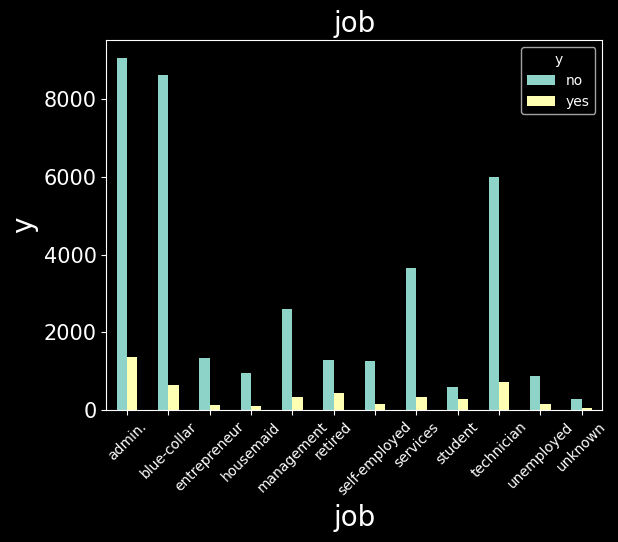

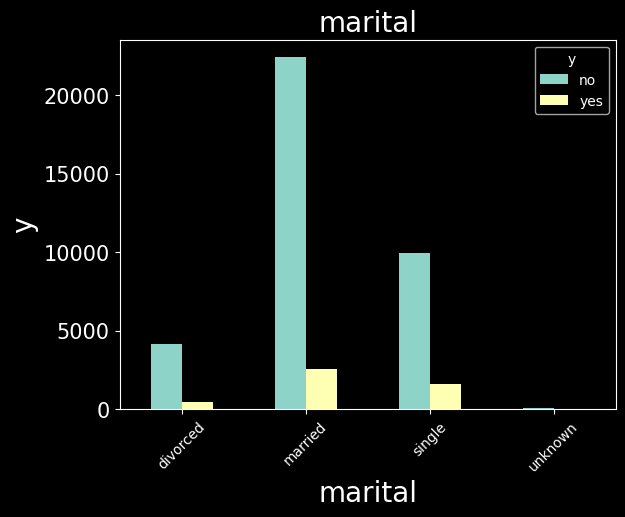

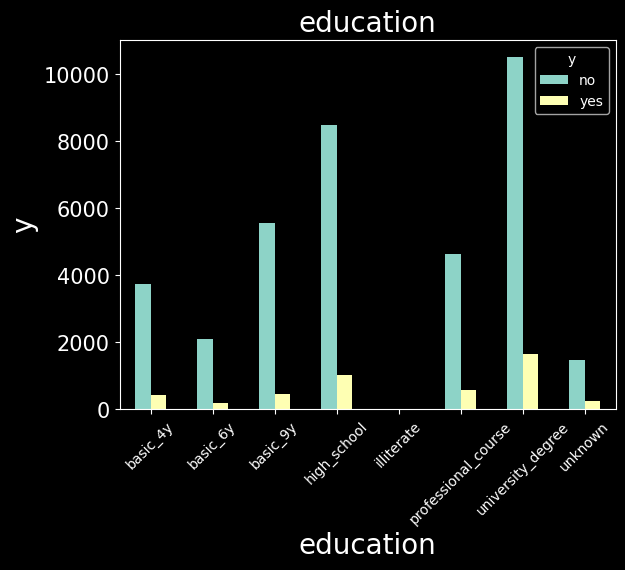

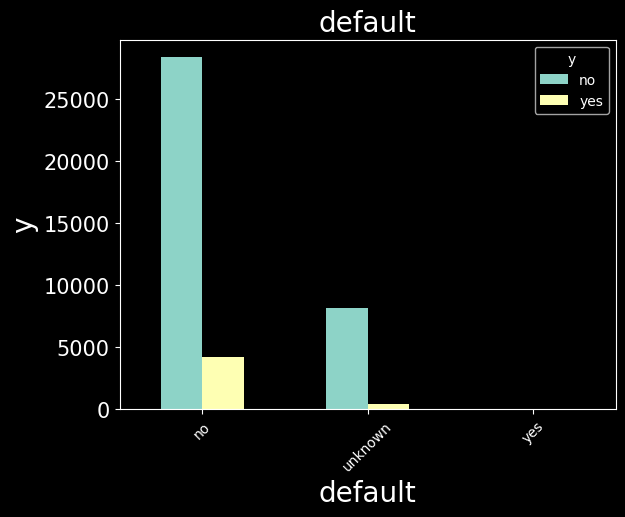

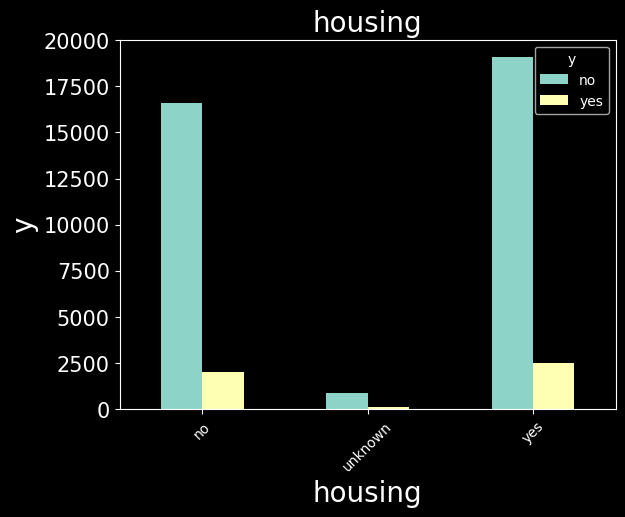

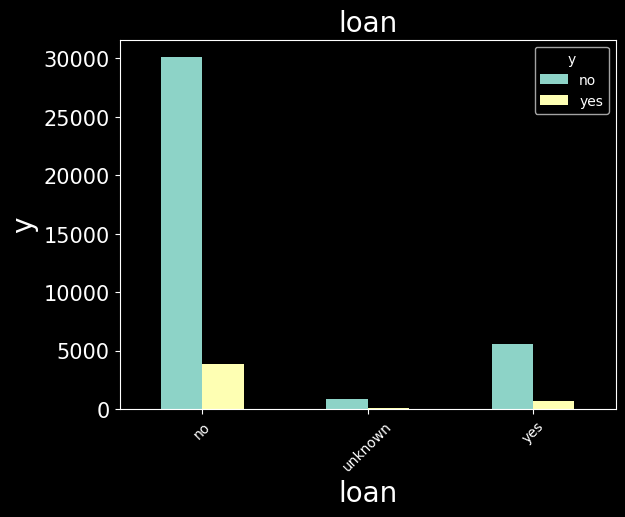

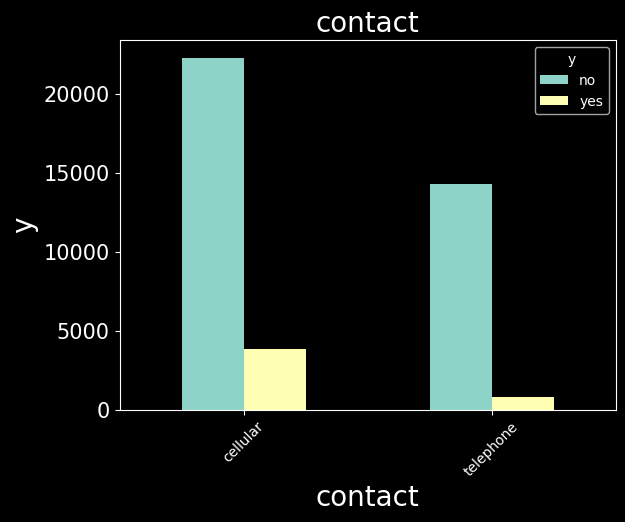

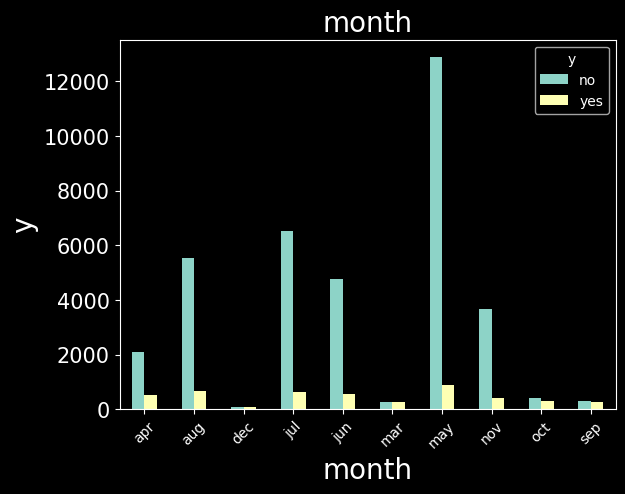

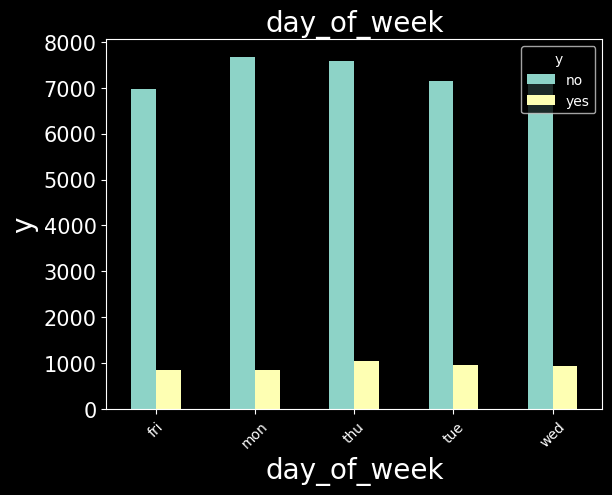

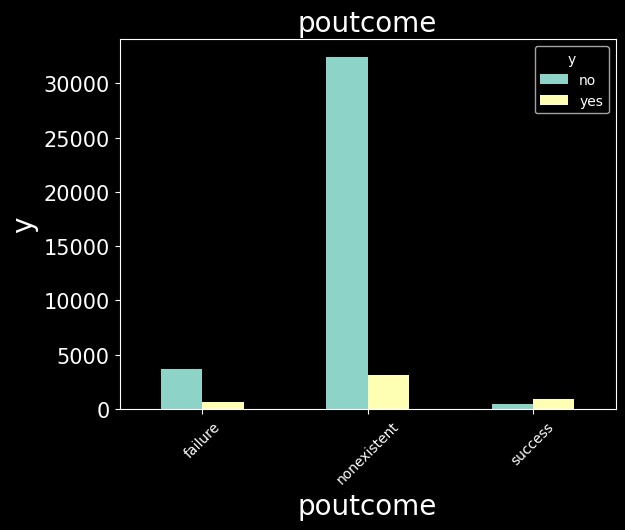

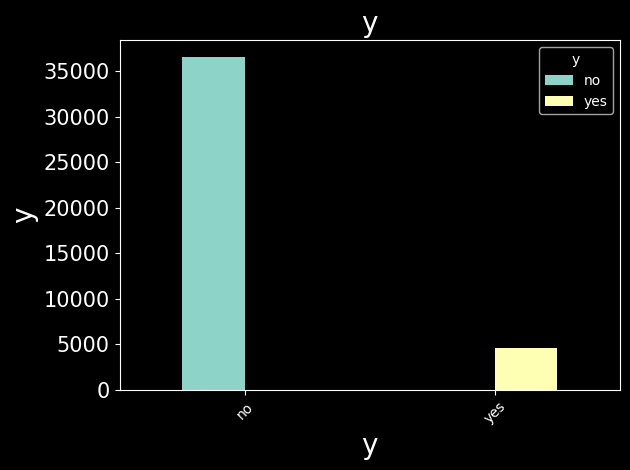

In [35]:
from matplotlib import cm
# fig = plt.figure(figsize=(25,15)) ## Plot Size 
# st = fig.suptitle("Distribution of Features", fontsize=50,
#                   verticalalignment='center') # Plot Main Title 

for col,num in zip(cat_columns, range(1,15)):
#     #print(col)
#     a = df.toPandas()[col].value_counts()
#     x = list(a.index)
#     y = list(a)
    
    width = 0.75 # the width of the bars 
    ind = np.arange(len(y))  # the x locations for the groups
    #ax= plt.subplot(8,2,num) 
    pd.crosstab(df1[col], df1['y']).plot(kind='bar', stacked=False)
      
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(x, minor=False)
#     for i, v in enumerate(y):
#         ax.text(v + .25, i + .25, str(v), fontweight='bold') #add value labels into bar
    plt.title(col,fontsize=20)
    plt.xlabel(col,fontsize=20)
    plt.ylabel("y",fontsize=20)
    plt.xticks(rotation=45,fontsize=10)
    plt.yticks(fontsize=15)
    filename1 = 'C:/Users/Xue/OneDrive - Oklahoma A and M System/BAN 5753/Mini project/mini 2/Figures/'+ str(col) + '.jpg'
    plt.savefig(filename1,bbox_inches='tight')
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()


According to the figures above, we can see for some varaibles, the yes rate of subscribe is very unbalanced for each categories of a variable. So next we will calculate Yes Rate in each group to determine how to group some variables. 

In [36]:
count_y_by_maritalGroup = df.groupBy('marital').agg(
    F.sum(F.when(df['y'] == 'yes', 1).otherwise(0)).alias('count_y_yes'),
    F.sum(F.when(df['y'] == 'no', 1).otherwise(0)).alias('count_y_no')
)

count_y_by_maritalGroup2 = count_y_by_maritalGroup.withColumn('ratio', count_y_by_maritalGroup['count_y_yes'] / (count_y_by_maritalGroup['count_y_yes'] + count_y_by_maritalGroup['count_y_no']))
count_y_by_maritalGroup2 = count_y_by_maritalGroup2.withColumn('yes_rate', F.round(count_y_by_maritalGroup2['ratio'], 2))

count_y_by_maritalGroup2.select('marital','count_y_yes','count_y_no','yes_rate').show()

+--------+-----------+----------+--------+
| marital|count_y_yes|count_y_no|yes_rate|
+--------+-----------+----------+--------+
| unknown|         12|        68|    0.15|
|divorced|        476|      4136|     0.1|
| married|       2532|     22396|     0.1|
|  single|       1620|      9948|    0.14|
+--------+-----------+----------+--------+



In [37]:
count_y_by_educationGroup = df.groupBy('education').agg(
    F.sum(F.when(df['y'] == 'yes', 1).otherwise(0)).alias('count_y_yes'),
    F.sum(F.when(df['y'] == 'no', 1).otherwise(0)).alias('count_y_no')
)

count_y_by_educationGroup2 = count_y_by_educationGroup.withColumn('ratio', count_y_by_educationGroup['count_y_yes'] / (count_y_by_educationGroup['count_y_yes'] + count_y_by_educationGroup['count_y_no']))
count_y_by_educationGroup2 = count_y_by_educationGroup2.withColumn('yes_rate', F.round(count_y_by_educationGroup2['ratio'], 2))

count_y_by_educationGroup2.select('education','count_y_yes','count_y_no','yes_rate').show()

+-------------------+-----------+----------+--------+
|          education|count_y_yes|count_y_no|yes_rate|
+-------------------+-----------+----------+--------+
|professional_course|        595|      4648|    0.11|
|           basic_4y|        428|      3748|     0.1|
|            unknown|        251|      1480|    0.15|
|           basic_9y|        473|      5572|    0.08|
|         illiterate|          4|        14|    0.22|
|           basic_6y|        188|      2104|    0.08|
|        high_school|       1031|      8484|    0.11|
|  university_degree|       1670|     10498|    0.14|
+-------------------+-----------+----------+--------+



In [38]:

count_y_by_monthGroup = df.groupBy('month').agg(
    F.sum(F.when(df['y'] == 'yes', 1).otherwise(0)).alias('count_y_yes'),
    F.sum(F.when(df['y'] == 'no', 1).otherwise(0)).alias('count_y_no')
)

count_y_by_monthGroup2 = count_y_by_monthGroup.withColumn('ratio', count_y_by_monthGroup['count_y_yes'] / (count_y_by_monthGroup['count_y_yes'] + count_y_by_monthGroup['count_y_no']))
count_y_by_monthGroup2 = count_y_by_monthGroup2.withColumn('yes_rate', F.round(count_y_by_monthGroup2['ratio'], 2))

count_y_by_monthGroup2.select('month','count_y_yes','count_y_no','yes_rate').show()

+-----+-----------+----------+--------+
|month|count_y_yes|count_y_no|yes_rate|
+-----+-----------+----------+--------+
|  jun|        559|      4759|    0.11|
|  aug|        655|      5523|    0.11|
|  may|        886|     12883|    0.06|
|  mar|        276|       270|    0.51|
|  oct|        315|       403|    0.44|
|  jul|        649|      6525|    0.09|
|  nov|        416|      3685|     0.1|
|  apr|        539|      2093|     0.2|
|  dec|         89|        93|    0.49|
|  sep|        256|       314|    0.45|
+-----+-----------+----------+--------+



## 1.9 Bivariate analysis of target versus numerical input variables

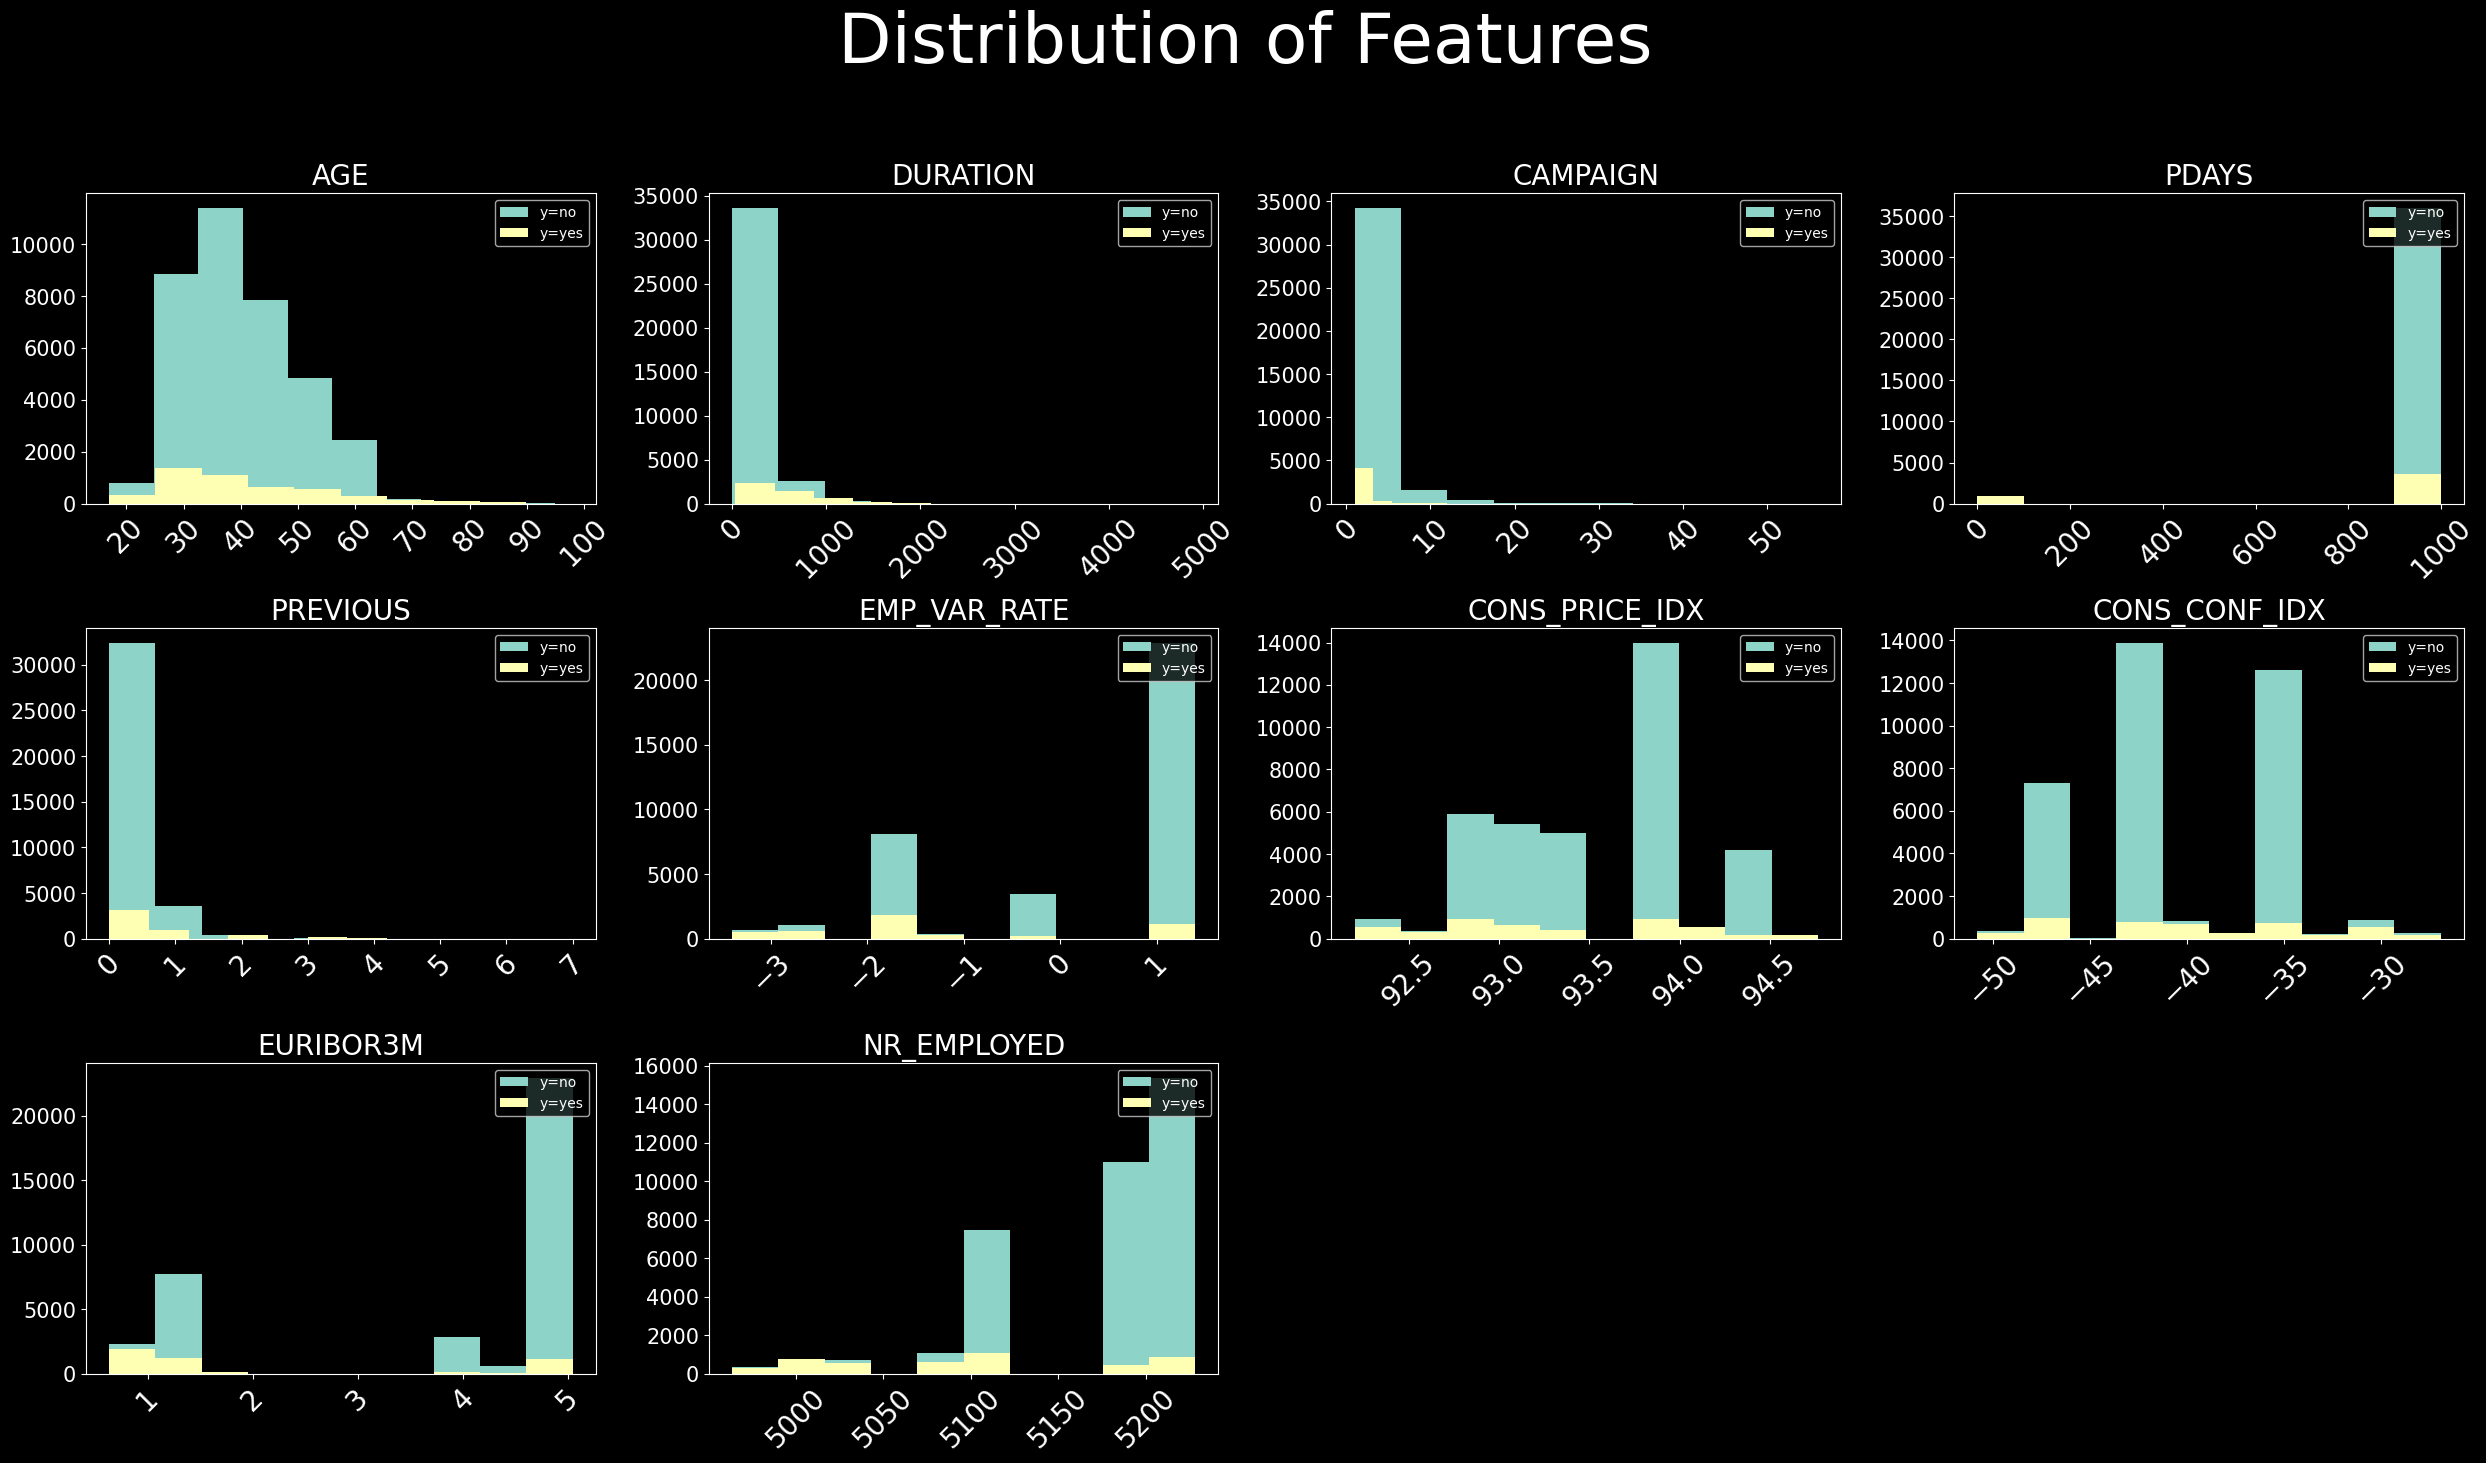

In [46]:
### Histogram for y=yes/no for each numerical variable
from matplotlib import cm
df1 = df.toPandas()['y']=='yes'
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().describe().columns, range(1,12)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.filter(df.y == 'no').toPandas()[col],label='y=no')
    ax.hist(df.filter(df.y == 'yes').toPandas()[col],label='y=yes')
    
    plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
    plt.legend(loc='upper right')
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

## 1.10 Prescriptive Recommendations
Based on this analysis, we have seen a higher subscribe rate among

* Highly educated
* Single people
* Special months (Mar. & Sep. & Otc. & Dec)

To capitalize on that, we should focus advertising on that demographic with targeted advertising in special months (Mar. & Sep. & Otc. & Dec), highly educated and single people!

## 1.10 Group some variables including both numerical and categorical into some groups

### a ) Create a new column "pdays_udf" and drop "pdays"

In [24]:
from pyspark.sql.functions import udf
y_udf = udf(lambda y: 1 if y==999 else 0, StringType())

df=df.withColumn("pdays_udf", y_udf('pdays')).drop("pdays")

In [25]:
df.groupBy("pdays_udf").count().orderBy("count", ascending=False).show(truncate=False)

+---------+-----+
|pdays_udf|count|
+---------+-----+
|1        |39673|
|0        |1515 |
+---------+-----+



### b ) Create a new column "euribor3m_udf" and drop "euribor3m"

In [26]:
from pyspark.sql.functions import udf
y_udf = udf(lambda y: 1 if y>3 else 0, StringType())

df=df.withColumn("euribor3m_udf", y_udf('euribor3m')).drop("euribor3m")

In [27]:
df.groupBy("euribor3m_udf").count().orderBy("count", ascending=False).show(truncate=False)

+-------------+-----+
|euribor3m_udf|count|
+-------------+-----+
|1            |27690|
|0            |13498|
+-------------+-----+



### c ) Create a new column "education_udf" and drop "education"

In [28]:
from pyspark.sql.functions import udf
y_udf = udf(lambda y: 1 if y=="university_degree" else 0, StringType())

df=df.withColumn("education_udf", y_udf('education')).drop("education")

In [29]:
df.groupBy("education_udf").count().orderBy("count", ascending=False).show(truncate=False)

+-------------+-----+
|education_udf|count|
+-------------+-----+
|0            |29020|
|1            |12168|
+-------------+-----+



### d) Create a new column "month_udf" and drop "month"

In [30]:
from pyspark.sql.functions import udf
y_udf = udf(lambda y: 1 if (y=="mar") or (y=="sep") or (y=="otc")or (y=="dec") else 0, StringType())

df=df.withColumn("month_udf", y_udf('month')).drop("month")

In [31]:
df.groupBy("month_udf").count().orderBy("count", ascending=False).show(truncate=False)

+---------+-----+
|month_udf|count|
+---------+-----+
|0        |39890|
|1        |1298 |
+---------+-----+



# 2. Prepare Data for Machine Learning

## 2.1 StringIndexer

In [32]:
df2=df

In [33]:
Indexers = [StringIndexer(inputCol="job", outputCol="jobIndex"), 
            StringIndexer(inputCol="default", outputCol="defaultIndex"), 
            StringIndexer(inputCol="housing", outputCol="housingIndex"),
            StringIndexer(inputCol="loan", outputCol="loanIndex"),
            StringIndexer(inputCol="contact", outputCol="contactIndex"),
            StringIndexer(inputCol="day_of_week", outputCol="day_of_weekIndex"),
            StringIndexer(inputCol="poutcome", outputCol="poutcomeIndex"),                
            StringIndexer(inputCol="pdays_udf", outputCol="pdays_udfIndex"),
            StringIndexer(inputCol="euribor3m_udf", outputCol="euribor3m_udfIndex"),
            StringIndexer(inputCol="education_udf", outputCol="education_udfIndex"),
            StringIndexer(inputCol="marital", outputCol="marital_Index"),
            StringIndexer(inputCol="month_udf", outputCol="month_udfIndex")   
            ]

pipeline = Pipeline(stages=Indexers)
Index_df = pipeline.fit(df2).transform(df2)

## 2.2 OneHotEncoderEstimator

In [34]:
encoder = [OneHotEncoder(inputCol="jobIndex", outputCol="jobencoded"), 
           OneHotEncoder(inputCol="defaultIndex", outputCol="defaultencoded"), 
           OneHotEncoder(inputCol="housingIndex", outputCol="housingencoded"),
           OneHotEncoder(inputCol="loanIndex", outputCol="loanencoded"),
           OneHotEncoder(inputCol="contactIndex", outputCol="contactencoded"),
           OneHotEncoder(inputCol="day_of_weekIndex", outputCol="day_of_weekencoded"),
           OneHotEncoder(inputCol="poutcomeIndex", outputCol="poutcomeencoded"),   
           OneHotEncoder(inputCol="pdays_udfIndex", outputCol="pdays_udfencoded"),
           OneHotEncoder(inputCol="euribor3m_udfIndex", outputCol="euribor3m_udfencoded"),
           OneHotEncoder(inputCol="education_udfIndex", outputCol="education_udfencoded"),
           OneHotEncoder(inputCol="marital_Index", outputCol="marital_encoded"),
           OneHotEncoder(inputCol="month_udfIndex", outputCol="month_encoded")
           ]

pipeline = Pipeline(stages=encoder)
encoder_df = pipeline.fit(Index_df).transform(Index_df)

## 2.3 VectorAssembler

In [35]:
import pandas as pd
pd.set_option('display.max_colwidth', 80)
pd.set_option("display.max_columns", 12)

In [36]:
assembler = VectorAssembler()\
         .setInputCols (['age',
                         'duration',
                         'campaign',
                         'previous',
                         'jobencoded',
                         'cons_price_idx',
                         'cons_conf_idx',
                         'nr_employed',
                         'duration',
                         'defaultencoded',
                         'housingencoded',
                         'loanencoded',
                         'contactencoded',
                         'day_of_weekencoded',
                         'poutcomeencoded',
                         'pdays_udfencoded',
                         'euribor3m_udfencoded',
                         'education_udfencoded',
                         'marital_encoded',
                         'month_encoded']).setOutputCol ("vectorized_features")
        
# In case of missing you can skip the invalid ones
assembler_df=assembler.setHandleInvalid("skip").transform(encoder_df)
assembler_df.toPandas().head()

,age,job,marital,default,housing,loan,...,pdays_udfencoded,euribor3m_udfencoded,education_udfencoded,marital_encoded,month_encoded,vectorized_features
0,56,housemaid,married,no,no,no,...,(1.0),(1.0),(1.0),"(1.0, 0.0, 0.0)",(1.0),"(56.0, 261.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0...."
1,57,services,married,unknown,no,no,...,(1.0),(1.0),(1.0),"(1.0, 0.0, 0.0)",(1.0),"(57.0, 149.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
2,37,services,married,no,yes,no,...,(1.0),(1.0),(1.0),"(1.0, 0.0, 0.0)",(1.0),"(37.0, 226.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
3,40,admin.,married,no,no,no,...,(1.0),(1.0),(1.0),"(1.0, 0.0, 0.0)",(1.0),"(40.0, 151.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
4,56,services,married,no,no,yes,...,(1.0),(1.0),(1.0),"(1.0, 0.0, 0.0)",(1.0),"(56.0, 307.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."


## 2.4 LabelIndexer

In [37]:
label_indexer = StringIndexer()\
         .setInputCol ("y")\
         .setOutputCol ("label")

label_indexer_model=label_indexer.fit(assembler_df)
label_indexer_df=label_indexer_model.transform(assembler_df)

In [38]:
label_indexer_df.toPandas().head(5)

,age,job,marital,default,housing,loan,...,euribor3m_udfencoded,education_udfencoded,marital_encoded,month_encoded,vectorized_features,label
0,56,housemaid,married,no,no,no,...,(1.0),(1.0),"(1.0, 0.0, 0.0)",(1.0),"(56.0, 261.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0....",0.0
1,57,services,married,unknown,no,no,...,(1.0),(1.0),"(1.0, 0.0, 0.0)",(1.0),"(57.0, 149.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",0.0
2,37,services,married,no,yes,no,...,(1.0),(1.0),"(1.0, 0.0, 0.0)",(1.0),"(37.0, 226.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",0.0
3,40,admin.,married,no,no,no,...,(1.0),(1.0),"(1.0, 0.0, 0.0)",(1.0),"(40.0, 151.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",0.0
4,56,services,married,no,no,yes,...,(1.0),(1.0),"(1.0, 0.0, 0.0)",(1.0),"(56.0, 307.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",0.0


# 2.5 StandardScaler

In [39]:
scaler = StandardScaler()\
         .setInputCol ("vectorized_features")\
         .setOutputCol ("features")
        
scaler_model=scaler.fit(label_indexer_df)
scaler_df=scaler_model.transform(label_indexer_df)
pd.set_option('display.max_colwidth', 40)
scaler_df.select("vectorized_features","features").toPandas().head(5)

,vectorized_features,features
0,"(56.0, 261.0, 1.0, 0.0, 0.0, 0.0, 0....","(5.373635610167056, 1.00663667135436..."
1,"(57.0, 149.0, 1.0, 0.0, 0.0, 0.0, 0....","(5.469593388920039, 0.57466997713333..."
2,"(37.0, 226.0, 1.0, 0.0, 0.0, 0.0, 0....","(3.550437813860376, 0.87164707941029..."
3,"(40.0, 151.0, 1.0, 0.0, 1.0, 0.0, 0....","(3.838311150119326, 0.58238366810156..."
4,"(56.0, 307.0, 1.0, 0.0, 0.0, 0.0, 0....","(5.373635610167056, 1.18405156362372..."


## 2.6 K Means Cluster

In [40]:
from pyspark.ml.clustering import KMeans
KMeans_algo=KMeans(featuresCol='features', k=4)
KMeans_fit=KMeans_algo.fit(scaler_df)
df11=KMeans_fit.transform(scaler_df)

In [41]:
df111 = df11.withColumnRenamed('prediction', 'k_cluster')

In [42]:
df111.toPandas().head(5)

,age,job,marital,default,housing,loan,...,marital_encoded,month_encoded,vectorized_features,label,features,k_cluster
0,56,housemaid,married,no,no,no,...,"(1.0, 0.0, 0.0)",(1.0),"(56.0, 261.0, 1.0, 0.0, 0.0, 0.0, 0....",0.0,"(5.373635610167056, 1.00663667135436...",0
1,57,services,married,unknown,no,no,...,"(1.0, 0.0, 0.0)",(1.0),"(57.0, 149.0, 1.0, 0.0, 0.0, 0.0, 0....",0.0,"(5.469593388920039, 0.57466997713333...",0
2,37,services,married,no,yes,no,...,"(1.0, 0.0, 0.0)",(1.0),"(37.0, 226.0, 1.0, 0.0, 0.0, 0.0, 0....",0.0,"(3.550437813860376, 0.87164707941029...",0
3,40,admin.,married,no,no,no,...,"(1.0, 0.0, 0.0)",(1.0),"(40.0, 151.0, 1.0, 0.0, 1.0, 0.0, 0....",0.0,"(3.838311150119326, 0.58238366810156...",0
4,56,services,married,no,no,yes,...,"(1.0, 0.0, 0.0)",(1.0),"(56.0, 307.0, 1.0, 0.0, 0.0, 0.0, 0....",0.0,"(5.373635610167056, 1.18405156362372...",1


In [43]:
df111 = df111.drop('features')

In [44]:
df111 = df111.drop('vectorized_features')

In [45]:
assembler2 = VectorAssembler()\
         .setInputCols (['age',
                         'duration',
                         'campaign',
                         'previous',
                         'jobencoded',
                         
                         'cons_price_idx',
                         'cons_conf_idx',
                         'nr_employed',
                         'duration',
                         'defaultencoded',
                         'housingencoded',
                         'loanencoded',
                         'contactencoded',
                         'day_of_weekencoded',
                         'poutcomeencoded',
                         'pdays_udfencoded',
                         'euribor3m_udfencoded',
                         'education_udfencoded',
                         'marital_encoded',
                         'month_encoded',
                        'k_cluster']).setOutputCol ("vectorized_features")
        
# In case of missing you can skip the invalid ones
assembler_df=assembler2.setHandleInvalid("skip").transform(df111)
assembler_df.toPandas().head()

,age,job,marital,default,housing,loan,...,education_udfencoded,marital_encoded,month_encoded,label,k_cluster,vectorized_features
0,56,housemaid,married,no,no,no,...,(1.0),"(1.0, 0.0, 0.0)",(1.0),0.0,0,"(56.0, 261.0, 1.0, 0.0, 0.0, 0.0, 0...."
1,57,services,married,unknown,no,no,...,(1.0),"(1.0, 0.0, 0.0)",(1.0),0.0,0,"(57.0, 149.0, 1.0, 0.0, 0.0, 0.0, 0...."
2,37,services,married,no,yes,no,...,(1.0),"(1.0, 0.0, 0.0)",(1.0),0.0,0,"(37.0, 226.0, 1.0, 0.0, 0.0, 0.0, 0...."
3,40,admin.,married,no,no,no,...,(1.0),"(1.0, 0.0, 0.0)",(1.0),0.0,0,"(40.0, 151.0, 1.0, 0.0, 1.0, 0.0, 0...."
4,56,services,married,no,no,yes,...,(1.0),"(1.0, 0.0, 0.0)",(1.0),0.0,1,"(56.0, 307.0, 1.0, 0.0, 0.0, 0.0, 0...."


In [46]:
scaler = StandardScaler()\
         .setInputCol ("vectorized_features")\
         .setOutputCol ("features")
        
scaler_model=scaler.fit(assembler_df)
scaler_df=scaler_model.transform(assembler_df)
pd.set_option('display.max_colwidth', 40)
scaler_df.select("vectorized_features","features").toPandas().head(5)

,vectorized_features,features
0,"(56.0, 261.0, 1.0, 0.0, 0.0, 0.0, 0....","(5.373635610167056, 1.00663667135436..."
1,"(57.0, 149.0, 1.0, 0.0, 0.0, 0.0, 0....","(5.469593388920039, 0.57466997713333..."
2,"(37.0, 226.0, 1.0, 0.0, 0.0, 0.0, 0....","(3.550437813860376, 0.87164707941029..."
3,"(40.0, 151.0, 1.0, 0.0, 1.0, 0.0, 0....","(3.838311150119326, 0.58238366810156..."
4,"(56.0, 307.0, 1.0, 0.0, 0.0, 0.0, 0....","(5.373635610167056, 1.18405156362372..."


# 3. Train / Test Split

In [47]:
final_df = scaler_df.select('features', 'label')

In [48]:
train, test = final_df.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 32958
Test Dataset Count: 8230


In [49]:
train.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|29251|
|  1.0| 3707|
+-----+-----+



# 4. Confusion Matrix

In [50]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 5. Model Trainning

## Model # 1: Logistic Regression

In [51]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train)
predictions_lr = lrModel.transform(test)
#predictions_train = lrModel.transform(train)
predictions_lr.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(2.8787333625894944, 0.6440931958474...","[4.002626911709836, -4.002626911709836]",0.0,"[0.9820601297053974, 0.0179398702946..."
1,0.0,"(2.782775583836511, 1.21490632749665...","[3.19432342939799, -3.19432342939799]",0.0,"[0.9606200981014174, 0.0393799018985..."
2,0.0,"(3.35852225635441, 0.736657487466224...","[3.679984691110903, -3.679984691110903]",0.0,"[0.9753972042248954, 0.0246027957751..."
3,0.0,"(3.0706489200954605, 1.9477069694787...","[2.4858934235104364, -2.485893423510...",0.0,"[0.9231469606050802, 0.0768530393949..."
4,0.0,"(2.590860026330545, 1.02977774425906...","[2.6183149211992998, -2.618314921199...",0.0,"[0.932031035737913, 0.06796896426208..."


Confusion matrix, without normalization
[[ 328  605]
 [ 193 7104]]
precision_score :
 0.6295585412667947
recall_score :
 0.3515541264737406


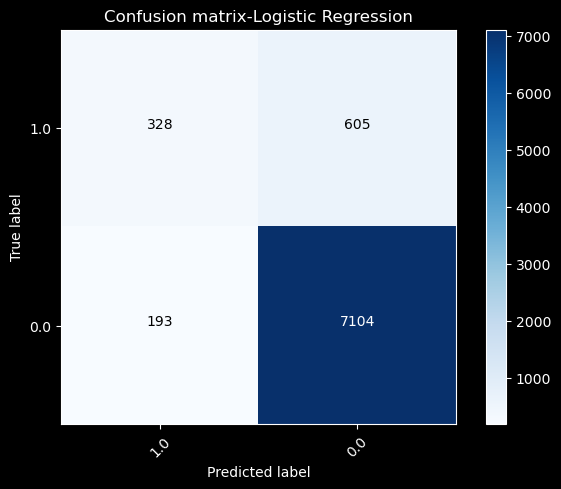

In [52]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,classification_report

y_true = predictions_lr.select("label")
y_true = y_true.toPandas()

y_pred = predictions_lr.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix-Logistic Regression')
print('precision_score :\n',precision_score(y_true,y_pred,pos_label=1))
print('recall_score :\n',recall_score(y_true,y_pred,pos_label=1))
plt.show()

In [53]:
accuracy = predictions_lr.filter(predictions_lr.label == predictions_lr.prediction).count() / float(predictions_lr.count())
print("Accuracy-Logistic Regression: ",accuracy)

Accuracy-Logistic Regression:  0.903037667071689


In [54]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC-Logistic Regression', evaluator.evaluate(predictions_lr))

Test Area Under ROC-Logistic Regression 0.9200445909953451


## Model # 2: Decision Tree

In [55]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label')
dtModel = dt.fit(train)
predictions_dt = dtModel.transform(test)
#predictions_train = lrModel.transform(train)
predictions_dt.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(2.8787333625894944, 0.6440931958474...","[23930.0, 396.0]",0.0,"[0.9837211214338568, 0.0162788785661..."
1,0.0,"(2.782775583836511, 1.21490632749665...","[23930.0, 396.0]",0.0,"[0.9837211214338568, 0.0162788785661..."
2,0.0,"(3.35852225635441, 0.736657487466224...","[23930.0, 396.0]",0.0,"[0.9837211214338568, 0.0162788785661..."
3,0.0,"(3.0706489200954605, 1.9477069694787...","[23930.0, 396.0]",0.0,"[0.9837211214338568, 0.0162788785661..."
4,0.0,"(2.590860026330545, 1.02977774425906...","[23930.0, 396.0]",0.0,"[0.9837211214338568, 0.0162788785661..."


Confusion matrix, without normalization
[[ 473  460]
 [ 291 7006]]


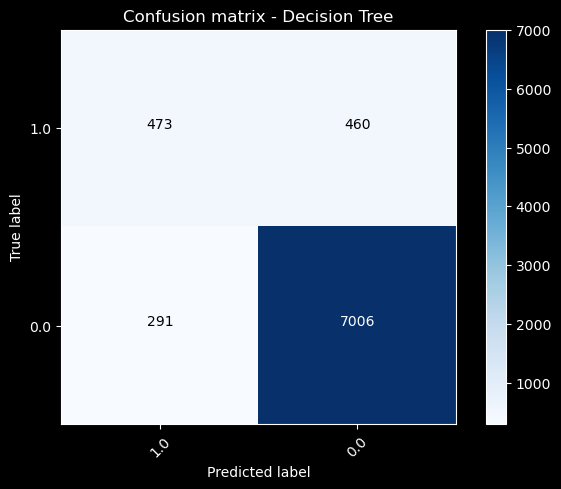

In [56]:
y_true = predictions_dt.select("label")
y_true = y_true.toPandas()

y_pred = predictions_dt.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix - Decision Tree')
plt.show()

In [57]:
accuracy = predictions_dt.filter(predictions_dt.label == predictions_dt.prediction).count() / float(predictions_dt.count())
print("Accuracy-Decision Tree : ",accuracy)

Accuracy-Decision Tree :  0.9087484811664641


In [58]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC-Decision Tree', evaluator.evaluate(predictions_dt))

Test Area Under ROC-Decision Tree 0.645253573647042


## Model # 3: Random Forest

In [59]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', numTrees=10)
rfModel = rf.fit(train)
predictions_rf = rfModel.transform(test)
#predictions_train = lrModel.transform(train)
predictions_rf.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(2.8787333625894944, 0.6440931958474...","[9.50345035404685, 0.4965496459531506]",0.0,"[0.950345035404685, 0.04965496459531..."
1,0.0,"(2.782775583836511, 1.21490632749665...","[9.443901464945965, 0.5560985350540354]",0.0,"[0.9443901464945965, 0.0556098535054..."
2,0.0,"(3.35852225635441, 0.736657487466224...","[9.50345035404685, 0.4965496459531506]",0.0,"[0.950345035404685, 0.04965496459531..."
3,0.0,"(3.0706489200954605, 1.9477069694787...","[8.94037927693656, 1.0596207230634396]",0.0,"[0.8940379276936561, 0.1059620723063..."
4,0.0,"(2.590860026330545, 1.02977774425906...","[8.914477140294691, 1.085522859705309]",0.0,"[0.8914477140294691, 0.1085522859705..."


Confusion matrix, without normalization
[[ 171  762]
 [  65 7232]]


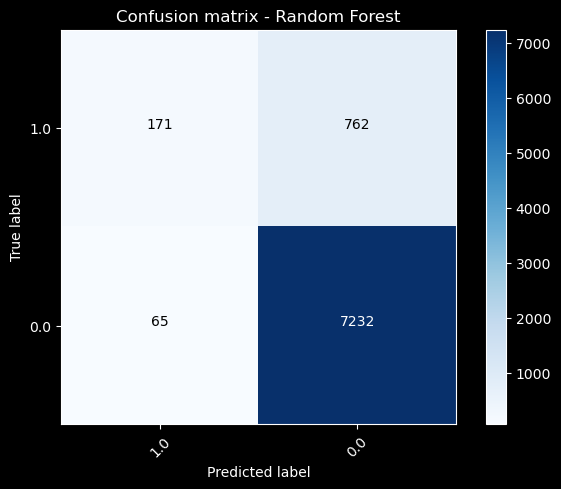

In [60]:
y_true = predictions_rf.select("label")
y_true = y_true.toPandas()

y_pred = predictions_rf.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix - Random Forest')
plt.show()

In [61]:
accuracy = predictions_rf.filter(predictions_rf.label == predictions_rf.prediction).count() / float(predictions_rf.count())
print("Accuracy-Random Forest : ",accuracy)

Accuracy-Random Forest :  0.8995139732685298


In [62]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC-Random Forest', evaluator.evaluate(predictions_rf))

Test Area Under ROC-Random Forest 0.9166324794535218


## Model # 4: Gradient-boosted tree

In [63]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10)
gbtModel = gbt.fit(train)
predictions_gbt = gbtModel.transform(test)
#predictions_train = lrModel.transform(train)
predictions_gbt.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(2.8787333625894944, 0.6440931958474...","[1.301510405886991, -1.301510405886991]",0.0,"[0.9310557411057379, 0.0689442588942..."
1,0.0,"(2.782775583836511, 1.21490632749665...","[1.242110003725192, -1.242110003725192]",0.0,"[0.9230281532421358, 0.0769718467578..."
2,0.0,"(3.35852225635441, 0.736657487466224...","[1.301510405886991, -1.301510405886991]",0.0,"[0.9310557411057379, 0.0689442588942..."
3,0.0,"(3.0706489200954605, 1.9477069694787...","[0.5776205708909253, -0.577620570890...",0.0,"[0.7604669304059296, 0.2395330695940..."
4,0.0,"(2.590860026330545, 1.02977774425906...","[1.206493887143587, -1.206493887143587]",0.0,"[0.9178123397254279, 0.0821876602745..."


Confusion matrix, without normalization
[[ 478  455]
 [ 297 7000]]


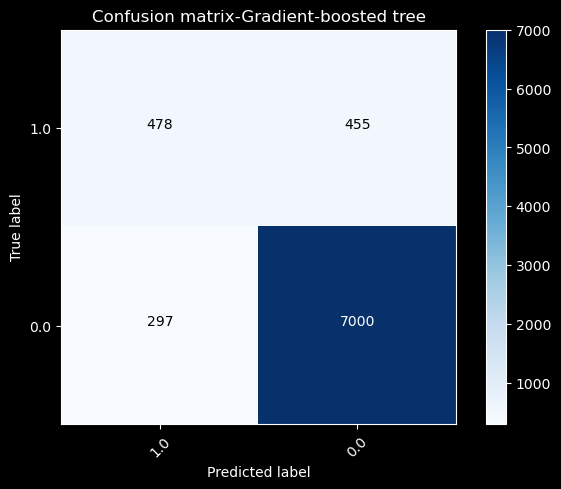

In [64]:
y_true = predictions_gbt.select("label")
y_true = y_true.toPandas()

y_pred = predictions_gbt.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix-Gradient-boosted tree')
plt.show()

In [65]:
accuracy = predictions_gbt.filter(predictions_gbt.label == predictions_gbt.prediction).count() / float(predictions_gbt.count())
print("Accuracy-Gradient-boosted tree : ",accuracy)

Accuracy-Gradient-boosted tree :  0.9086269744835966


In [66]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC-Gradient-boosted tree', evaluator.evaluate(predictions_gbt))

Test Area Under ROC-Gradient-boosted tree 0.9307024087921139


## Model # 5: Factorization machines classifier

In [67]:
from pyspark.ml.classification import FMClassifier
fm = FMClassifier(labelCol="label", featuresCol="features", stepSize=0.001)

# Train model.
fmModel = fm.fit(train)

# Make predictions.
predictions_fm = fmModel.transform(test)

# Select example rows to display.
predictions_fm.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(2.8787333625894944, 0.6440931958474...","[2.519761204232202, -2.519761204232202]",0.0,"[0.9255155947672404, 0.0744844052327..."
1,0.0,"(2.782775583836511, 1.21490632749665...","[1.8500587325967643, -1.850058732596...",0.0,"[0.8641339987229475, 0.1358660012770..."
2,0.0,"(3.35852225635441, 0.736657487466224...","[2.2937840207536233, -2.293784020753...",0.0,"[0.9083609241948741, 0.0916390758051..."
3,0.0,"(3.0706489200954605, 1.9477069694787...","[1.3322133264952143, -1.332213326495...",0.0,"[0.7912065092688283, 0.2087934907311..."
4,0.0,"(2.590860026330545, 1.02977774425906...","[1.6596697237250957, -1.659669723725...",0.0,"[0.8401936624140236, 0.1598063375859..."


Confusion matrix, without normalization
[[ 244  689]
 [ 125 7172]]


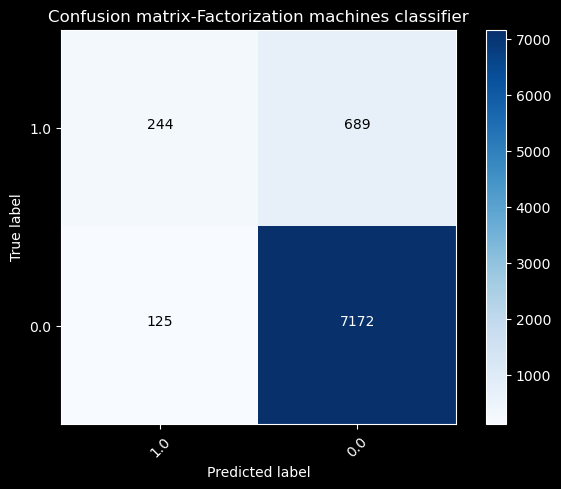

In [68]:
y_true = predictions_fm.select("label")
y_true = y_true.toPandas()

y_pred = predictions_fm.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix-Factorization machines classifier')
plt.show()

In [69]:
accuracy = predictions_fm.filter(predictions_fm.label == predictions_fm.prediction).count() / float(predictions_fm.count())
print("Accuracy-Factorization machines classifier : ",accuracy)

Accuracy-Factorization machines classifier :  0.901093560145808


In [70]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC-Factorization machines classifier', evaluator.evaluate(predictions_fm))

Test Area Under ROC-Factorization machines classifier 0.910115096706116


## 6. Model Comparision

The best supervised model is Gradient-boosted tree with 93.07% AUC and 90.86% accuracy.

Gradient-boosted tree model will be chosen as the champion since it performed best compared with other four models

## 7. Best Model Saving and Load for future use

In [71]:
save_path = "D:\model"

In [72]:
os.makedirs(save_path, exist_ok=True)

In [73]:
from pyspark.ml.classification import GBTClassifier
# gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10)
# gbtModel = gbt.fit(train)
gbtModel.write().overwrite().save(save_path)

In [ ]:
lr.write().overwrite().save(save_path)

In [ ]:
gbtModel = gbtModel.load(save_path)

In [ ]:
lr = lr.load(save_path)

## 8. Prescriptive Recommendations
Based on this analysis, we have seen a higher subscribe rate among

* Highly educated
* Single people
* Special months (Mar. & Sep. & Otc. & Dec)

To capitalize on that, we should focus advertising on that demographic with targeted advertising in special months (Mar. & Sep. & Otc. & Dec), highly educated and single people!